In [1]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm

Для начала распарсим датасет "по умолчанию".

In [2]:
import json
file = open('arxivData.json')
data = json.load(file)

In [3]:
def trl(container):
    return tqdm(range(len(container)))

def prepared(string):
    string = string.replace("'", '"')
    string = string.replace('None', 'null')
    return string

In [322]:
titles = [data[i]['title'] for i in trl(data)]
summaries = [data[i]['summary'] for i in trl(data)]
tags = [[json.loads(prepared(data[i]['tag']))[j]['term'] for j in range(len(json.loads(prepared(data[i]['tag']))))] for i in trl(data)]

Теперь соберем данные о тегах со страницы арксива.

In [4]:
import requests
page = requests.get("https://arxiv.org/category_taxonomy")

In [5]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: soup
  warnings.warn(message)


In [6]:
h4_cases = soup.find_all('h4')

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: h4_cases, soup
  warnings.warn(message)


In [7]:
tags_tags = h4_cases[1:]
possible_tags = set()
tag_to_id = {}
id_to_tag = {}
id_to_description = {}
for i, html_tag in enumerate(tags_tags):
    idx = html_tag.get_text().find(' ')
    tag = html_tag.get_text()[:idx]
    description = html_tag.get_text()[idx+2:-1]
    possible_tags.add(tag)
    tag_to_id[tag] = i
    id_to_tag[i] = tag
    id_to_description[i] = description

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: h4_cases, html_tag, soup, tags_tags
  warnings.warn(message)


In [8]:
num_tags = len(possible_tags)

In [328]:
with open('tags.txt', 'w') as file:
    for i in range(num_tags):
        file.write(str(id_to_tag[i]) + ' ' + str(id_to_description[i]) + '\n')

И переведем теги в индексы.

In [329]:
for i, line in enumerate(tags):
    line = list(set(line) & possible_tags)
    int_line = []
    for tag in line:
        int_line.append(tag_to_id[tag])
    tags[i] = int_line

Разобъем данные на трейн и тест...

In [330]:
from sklearn.model_selection import train_test_split

titles_train, titles_test, summaries_train, summaries_test, tags_train, tags_test = train_test_split(titles, summaries, tags, test_size=0.1, random_state=42)

И создадим датасеты и дадалоадеры.

In [9]:
#!g1.1
from transformers import AutoTokenizer, AutoModel, pipeline, DistilBertForSequenceClassification

base_model_name = 'distilbert-base-uncased'
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
#base_model = AutoModel.from_pretrained(base_model_name).to('cuda')

In [9]:
#!g1.1
base_tokenizer.save_pretrained('./tokenizer')

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [10]:
def multi_hot(indexes, num_classes):
    return torch.zeros((num_classes,)).scatter_(0, torch.tensor(indexes), torch.ones((num_classes,)))

In [11]:
from torch.utils.data import Dataset, DataLoader

class ArXivDataset(Dataset):
    def __init__(self, titles, abstracts, tags, possible_tags, tokenizer):
        super(ArXivDataset, self).__init__()
        self. titles = titles
        self.abstracts = abstracts
        self.tags = tags
        self.possible_tags = possible_tags
        self.num_classes = len(self.possible_tags)
        self.tokenizer = tokenizer
        
        self.inputs = ['Title: ' + self.titles[idx] + ' Abstract: ' + self.abstracts[idx] for idx in range(len(titles))]
        self.inputs = self.tokenizer(self.inputs, truncation=True, padding='max_length', max_length=512, return_tensors='pt')['input_ids']
    
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):
        return (self.inputs[idx], multi_hot(self.tags[idx], self.num_classes) / len(self.tags[idx]))

In [334]:
#!g1.1
base_train_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
base_test_ds = ArXivDataset(titles_test, summaries_test, tags_test, possible_tags, base_tokenizer)

base_train_dl = DataLoader(base_train_ds, shuffle=True, 
    batch_size=128, num_workers=0)
base_test_dl = DataLoader(base_test_ds, shuffle=True, 
    batch_size=128, num_workers=0)

small_ds = ArXivDataset(titles_train[:256], summaries_train[:256], tags_train[:256], possible_tags, base_tokenizer)
small_dl = DataLoader(small_ds, shuffle=True, 
    batch_size=128, num_workers=0)

Следующий класс в итоге не используется, мы будем использовать встроенную архитектуру головы классификатора.

In [12]:
#!g1.1
import torch.nn as nn
import torch.nn.functional as F

class BaseArXivClassifier(nn.Module):
    def __init__(self):
        super(BaseArXivClassifier, self).__init__()
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*768, 155),
            nn.Softmax(dim=1)
        )
    
    def forward(self, X):
        with torch.no_grad():
            X = base_model(X).last_hidden_state
        X = self.head(X)
        return X

Определим функции для тренировки и отрисовки графиков

In [13]:
import matplotlib.pyplot as plt

def plot_learning_process(train_loss, val_loss):    
    plt.figure()
    plt.title('loss by epoch')
    plt.plot(np.arange(0, len(val_loss))+0.5, train_loss, label='train')
    plt.plot(np.arange(0, len(val_loss))+1, val_loss, label='val')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.show()
    

In [14]:
#!g1.1

device = 'cuda'

import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    
    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
        
    train_loss = []
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)
        # evaluate
        output = F.softmax(model(X).logits, dim=1)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {train_loss[-1]:>8f}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))

    return {'train_loss': np.mean(train_loss)}
        
def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss = []
    
    with torch.no_grad():
        # evalute and check predictions
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
            X, y = X.to(device), y.to(device)
            output = F.softmax(model(X).logits, dim=1)
            loss = loss_fn(output, y)
            test_loss += loss.item()
                
            val_loss.append(loss.item())
            
    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")
    
    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    
    return {'val_loss': np.mean(val_loss)}

И натренируем нашу базовую модель.

In [338]:
#!g1.1
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

classifier = DistilBertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_tags).to('cuda')
for param in classifier.base_model.parameters():
    param.requires_grad = False

classifier.train()
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
epochs = 30

train_loss = []
val_loss = []
    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    train_loop(classifier, base_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, base_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w



Epoch 1
-------------------------------


Learning...

'[0/36900] Loss: 0.038880'

'[1845/36900] Loss: 0.034217'

'[3690/36900] Loss: 0.029051'

'[5535/36900] Loss: 0.021646'

'[7380/36900] Loss: 0.022256'

'[9225/36900] Loss: 0.023418'

'[11070/36900] Loss: 0.021545'

'[12915/36900] Loss: 0.021974'

'[14759/36900] Loss: 0.021328'

'[16605/36900] Loss: 0.020796'

KeyboardInterrupt: 

Прошу прощения, исходный output ячейки потерялся, потому что я случайно перезапустил эту ячейку когда тренировал следующую версию модели. Тем не менее, у меня сохранился график обучения, который я прилагаю здесь.
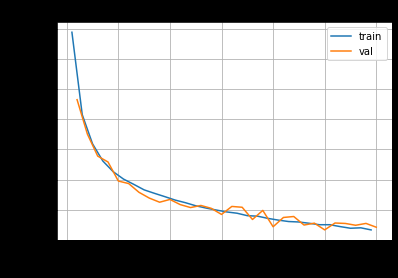

Сохраним ее чтобы иметь возможность использовать ее в интерфейсе.

In [66]:
#!g1.1
classifier.save_pretrained('./models')

Теперь попробуем повторить историю со специализированной моделью той же архитктуры, но предобученной на научных статьях.

In [312]:
#!g1.1
sci_model_name = 'allenai/scibert_scivocab_uncased'
sci_tokenizer = AutoTokenizer.from_pretrained(sci_model_name)

In [317]:
#!g1.1
sci_train_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, sci_tokenizer)
sci_test_ds = ArXivDataset(titles_test, summaries_test, tags_test, possible_tags, sci_tokenizer)

sci_train_dl = DataLoader(sci_train_ds, shuffle=True, 
    batch_size=256, num_workers=0)
sci_test_dl = DataLoader(sci_test_ds, shuffle=True, 
    batch_size=256, num_workers=0)

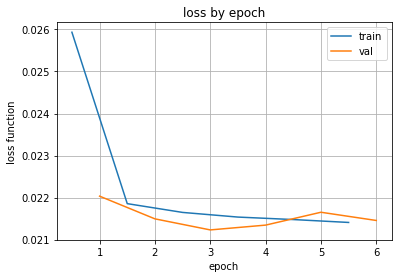

Epoch 7
-------------------------------


Learning...

'[0/36900] Loss: 0.021270'

'[1845/36900] Loss: 0.021709'

'[3690/36900] Loss: 0.021914'

'[5535/36900] Loss: 0.021512'

'[7380/36900] Loss: 0.020658'

'[9225/36900] Loss: 0.021273'

'[11070/36900] Loss: 0.021641'

'[12915/36900] Loss: 0.020861'

'[14759/36900] Loss: 0.021167'

'[16605/36900] Loss: 0.021825'

'[18449/36900] Loss: 0.021072'

'[20294/36900] Loss: 0.021985'

'[22140/36900] Loss: 0.020836'

'[23985/36900] Loss: 0.022309'

'[25830/36900] Loss: 0.021078'

'[27675/36900] Loss: 0.021097'

KeyboardInterrupt: 

In [318]:
#!g1.1
from transformers import AutoModelForSequenceClassification
sci_classifier = AutoModelForSequenceClassification.from_pretrained(sci_model_name, num_labels=num_tags).to('cuda')
for param in sci_classifier.base_model.parameters():
    param.requires_grad = False

sci_classifier.train()
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(sci_classifier.parameters(), lr=1e-4)
epochs = 30

train_loss = []
val_loss = []
    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    train_loop(sci_classifier, sci_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(sci_classifier, sci_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

Видим, что разницы в результатах не заметно, поэтому остановим обучение.

Теперь попробуем датасет побольше (существенно побольше). Он взят [отсюда](https://www.kaggle.com/datasets/Cornell-University/arxiv?select=arxiv-metadata-oai-snapshot.json). Мы используем только часть датасета (100'000 статей).

In [15]:
big_data = []
with open('arxiv-metadata-oai-snapshot.json') as big_file:
    for line in tqdm(big_file):
        big_data.append(json.loads(line))
        if len(big_data) >= 10**5:
            break

In [16]:
def trl(container):
    return tqdm(range(len(container)))

In [17]:
titles = [big_data[i]['title'] for i in trl(big_data)]
summaries = [big_data[i]['abstract'] for i in trl(big_data)]
tags = [big_data[i]['categories'].split() for i in trl(big_data)]

По каким-то причинам небольшая доля статей в этих данных не имеет ни одного тега из списка из 155 тегов, вытащенных нами с официальной страницы арксива. Чтобы избавиться от ситуации, когда у примера "нет правильных ответов" мы добавляем особый тег None, отвечающий за эту ситуацию. Разумеется, нам придется позже отфильтровать эту "заглушку" в пользовательской выдаче результатов. На практике, модель почти не пользуется этим тегом и предсказывает его очень редко и очень глубоко в списке тегов.

In [18]:
tag_to_id['None'] = 155
id_to_tag[155] = 'None'
id_to_description[155] = 'No tag'
possible_tags.add('None')

In [19]:
for i, line in enumerate(tags):
    line = list(set(line) & possible_tags)
    int_line = []
    for tag in line:
        int_line.append(tag_to_id[tag])
    if len(int_line) == 0:
        int_line.append(155)
    tags[i] = int_line

In [20]:
#!g1.1
from sklearn.model_selection import train_test_split

titles_train, titles_test, summaries_train, summaries_test, tags_train, tags_test = train_test_split(titles, summaries, tags, test_size=0.01, random_state=42)

In [21]:
#!g1.1
big_train_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
big_test_ds = ArXivDataset(titles_test, summaries_test, tags_test, possible_tags, base_tokenizer)

In [22]:
#!g1.1
big_train_dl = DataLoader(big_train_ds, shuffle=True, 
    batch_size=128, num_workers=0)
big_test_dl = DataLoader(big_test_ds, shuffle=True, 
    batch_size=128, num_workers=0)


Натренируем классификатор:

In [25]:
#!g1.1
classifier = DistilBertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_tags + 1).to('cuda')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

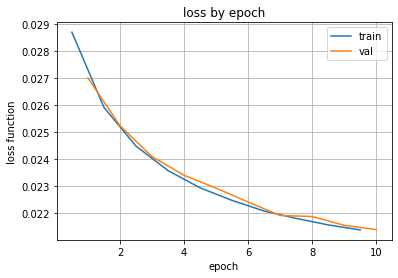

In [26]:
#!g1.1

from IPython.display import clear_output

for param in classifier.base_model.parameters():
    param.requires_grad = False

classifier.train()
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
epochs = 10

train_loss = []
val_loss = []
    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    train_loop(classifier, big_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, big_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

Видно, что 10 эпох недостаточно и хотелось бы потренироваться еще немного. Так и сделаем (предварительно сохранив классификатор на всякий случай):

In [27]:
#!g1.1
classifier.save_pretrained('./big_models')

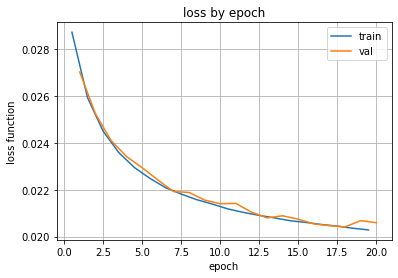

In [36]:
#!g1.1
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    train_loop(classifier, big_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, big_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

Эта версия используется в финальном сервисе, присланном в качестве решения.

Далее мы вводим несколько функции для обработки результатов и для визуального контроля качества модели.

In [30]:
#!g1.1

def top_xx(preds, xx=95):
    tops = torch.argsort(preds, 1, descending=True)
    total = 0
    index = 0
    result = []
    while total < xx / 100:
        next_id = tops[0, index].item()
        if next_id == 155:
            continue
        total += preds[0, next_id]
        index += 1
        result.append({'tag': id_to_tag[next_id], 'description': id_to_description[next_id]})
    return result

def print_data(idx):
    print('Title:')
    print(big_test_ds.titles[idx])
    print('\nAbstract:')
    print(big_test_ds.abstracts[idx])

def correct_classes(idx):
    return [id_to_tag[i] for i in big_test_ds.tags[idx]]

def top_xx_guesses(model, idx, xx):
    print(type(model(big_test_ds[idx][0].to('cuda').reshape(1, -1))))
    preds = F.softmax(model(big_test_ds[idx][0].to('cuda').reshape(1, -1)).logits, dim=1)
    return [tag['tag'] for tag in top_xx(preds, xx)]

In [31]:
#!g1.1
def press_x_to_win(idx, xx):
    print_data(idx)
    print('CORRECT:', correct_classes(idx))
    print('GUESSED:', top_xx_guesses(classifier, idx, xx))

In [35]:
#!g1.1
press_x_to_win(3, 70)

Title:
Light Bosons of Electromagnetic Field and Breakdown of Relativistic
  Theory

Abstract:
  In our analysis, a quantisation scheme for local electromagnetic waves in
vacuum is introduced by the model of nonideal Bose-gas consisting of
Bose-light-particles (which are no photons) with spin one and a finite mass.
This fact destroys the Relativistic Theory of Einstein as well as displays a
wrong sound of so-called a spontaneous breakdown of symmetry because the light
boson can be moved by speed of wave in vacuum.

CORRECT: ['physics.gen-ph']
<class 'transformers.modeling_outputs.SequenceClassifierOutput'>
GUESSED: ['quant-ph', 'hep-th', 'hep-ph', 'cond-mat.mes-hall', 'gr-qc', 'physics.gen-ph', 'math-ph', 'math.MP', 'math.DG', 'math.AG']
